## 1. Load Dữ liệu

In [9]:
import pandas as pd
import gdown

# 1. Khai báo ID file
file_id = '1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS'
url = f'https://drive.google.com/uc?id={file_id}'

# 2. Tải file về bộ nhớ tạm của Colab
output = 'data.json'
gdown.download(url, output, quiet=False)

# 3. Đọc file bằng Pandas
# Lưu ý: Nếu file lớn, hãy kiểm tra xem có cần lines=True không
try:
    df = pd.read_json(output)
    print("Đọc thành công!")
    print(df.head())
except ValueError:
    # Thử lại với lines=True nếu file JSON dạng mỗi dòng 1 object
    df = pd.read_json(output, lines=True)
    print("Đọc thành công với lines=True!")
    print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS
To: /content/data.json
100%|██████████| 3.48M/3.48M [00:00<00:00, 201MB/s]

Đọc thành công!
          aspect    sentiment       date   source  \
0     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   
1  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
2     Chính sách     Tiêu cực 2025-08-01  FireAnt   
3  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
4     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   

                                       original_text date_str  
0  Lên TT coi bà NPH nói về V mà sợ, bà đó hay th...      NaN  
1  Trụ gãy sạch ma20 nhưng midcap lại kéo trần? N...      NaN  
2  CHÍNH THỨC MỸ ÁP THUẾ 20% VỚI VIỆT NAM HẾT ĐỒN...      NaN  
3  Nay cuối tuần - phiên đầu tháng sau kỳ bctc Q2...      NaN  
4  ❤️❤️ suy nghĩ nào vhm bán đất hì hục 6 tháng l...      NaN  


## 2. Kiểm tra & Làm sạch Dữ liệu

In [10]:
# Thông tin tổng quan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   aspect         8199 non-null   object        
 1   sentiment      8199 non-null   object        
 2   date           8199 non-null   datetime64[ns]
 3   source         8199 non-null   object        
 4   original_text  8199 non-null   object        
 5   date_str       2568 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 384.5+ KB


In [11]:
# Kiểm tra giá trị null
print("Số lượng giá trị Null:")
print(df.isnull().sum())

# Chuyển cột 'date' sang kiểu datetime
df['date'] = pd.to_datetime(df['date'])

Số lượng giá trị Null:
aspect              0
sentiment           0
date                0
source              0
original_text       0
date_str         5631
dtype: int64


> **📝 Nhận xét:**
> Việc kiểm tra giá trị `Null` là cực kỳ quan trọng để đảm bảo tính toàn vẹn của dữ liệu. Nếu cột `original_text` có giá trị Null, ta cần loại bỏ hoặc xử lý các dòng đó trước khi train model. Việc chuyển đổi cột `date` sang kiểu datetime là bắt buộc để thực hiện các phân tích chuỗi thời gian sau này.

## 3. Phân tích Đơn biến (Univariate Analysis)

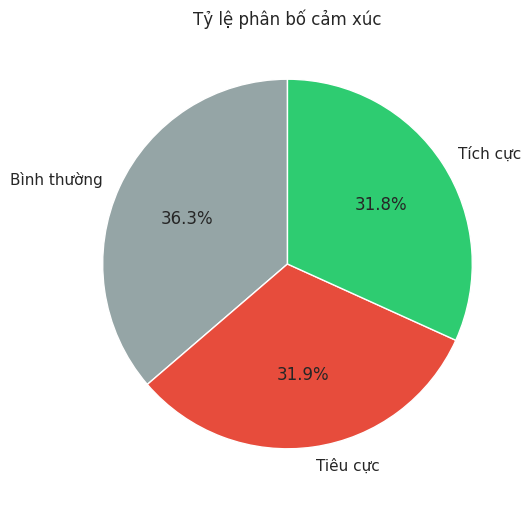

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
palette_sentiment = {
    'Tích cực': '#2ecc71',
    'Bình thường': '#95a5a6',
    'Tiêu cực': '#e74c3c'
}

# ------------------ BIỂU ĐỒ 1: TỶ LỆ PHÂN BỐ CẢM XÚC ------------------

sent_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    sent_counts,
    labels=sent_counts.index,
    autopct='%1.1f%%',
    colors=[palette_sentiment[k] for k in sent_counts.index],
    startangle=90
)
plt.title('Tỷ lệ phân bố cảm xúc')
plt.show()

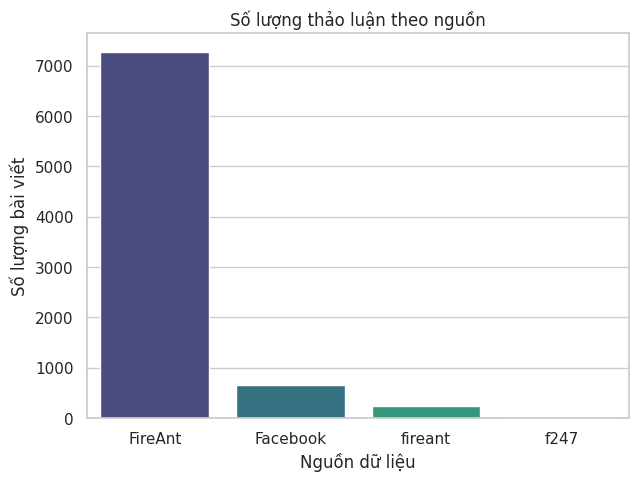

In [18]:
plt.figure(figsize=(7, 5))
sns.countplot(
    data=df,
    x='source',
    hue='source',
    palette='viridis',
    legend=False
)
plt.title('Số lượng thảo luận theo nguồn')
plt.xlabel('Nguồn dữ liệu')
plt.ylabel('Số lượng bài viết')
plt.show()

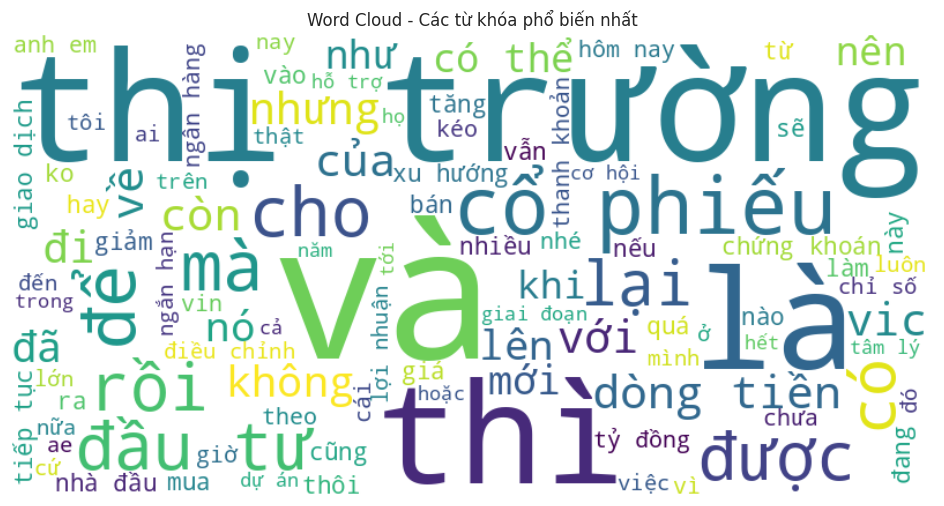

In [20]:
import re
from wordcloud import WordCloud

def clean_for_wordcloud(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # Bỏ link
    text = re.sub(r'[^\w\s]', '', text) # Bỏ ký tự đặc biệt
    return text

# Gộp tất cả văn bản
all_text = " ".join(df['original_text'].apply(clean_for_wordcloud))

# Tạo WordCloud
try:
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud.to_image(), interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Các từ khóa phổ biến nhất')
    plt.show()
except ValueError:
    print("Không đủ từ để tạo Word Cloud hoặc lỗi font Tiếng Việt (nếu chưa cài font).")

> **📝 Nhận xét:**
> Word Cloud trực quan hóa các từ khóa nổi bật nhất.
> - Những từ xuất hiện lớn nhất là những từ được nhắc đến nhiều nhất trong các thảo luận.
> - Cần lưu ý các "stop words" (từ dừng) như "là", "của", "và"... nếu chúng xuất hiện quá nhiều thì nên bổ sung vào danh sách loại bỏ để làm nổi bật các từ mang ý nghĩa thực sự (như "tăng", "giảm", "lãi", "lỗ", "mua", "bán").